In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.base import ClassifierMixin
from imblearn.ensemble import BalancedBaggingClassifier
from typing import Type

In [2]:
pd.set_option('display.max_columns', None)
sns.set()

# 1. Load Data

In [3]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')

In [4]:
df_train.shape

(11153, 22)

In [5]:
df_test.shape

(6000, 21)

In [6]:
df_train.head()

,job_level,job_duration_in_current_job_level,person_level,job_duration_in_current_person_level,job_duration_in_current_branch,Employee_type,gender,age,marital_status_maried(Y/N),number_of_dependences,Education_level,GPA,year_graduated,job_duration_from_training,branch_rotation,job_rotation,assign_of_otherposition,annual leave,sick_leaves,Last_achievement_%,Achievement_above_100%_during3quartal,Best Performance
0,JG04,1.352775,PG03,1.352775,1.732051,RM_type_A,2,1985,Y,1,level_0,2.86,2011,4,2,3,2,3,0,46.37,0.0,0
1,JG04,1.292285,PG03,1.292285,1.039230,RM_type_A,2,1989,Y,0,level_1,7.28,2007,4,4,3,0,0,1,47.68,0.0,0
2,JG05,2.565151,PG06,2.308679,1.780449,RM_type_C,1,1970,Y,1,level_1,0.00,1989,28,10,9,6,2,1,40.73,0.0,0
3,JG05,2.828427,PG06,1.000000,1.385641,RM_type_A,2,1967,Y,2,level_1,0.00,1987,29,11,6,0,4,10,47.42,0.0,1
4,JG05,2.828427,PG06,2.828427,0.707107,RM_type_A,2,1965,Y,3,level_1,7.20,1985,30,9,8,2,3,0,47.18,0.0,0


# 2. Check Missing Values

In [7]:
df_train.isna().sum()

job_level                                0
job_duration_in_current_job_level        0
person_level                             0
job_duration_in_current_person_level     0
job_duration_in_current_branch           0
Employee_type                            0
gender                                   0
age                                      0
marital_status_maried(Y/N)               0
number_of_dependences                    0
Education_level                          0
GPA                                      0
year_graduated                           0
job_duration_from_training               0
branch_rotation                          0
job_rotation                             0
assign_of_otherposition                  0
annual leave                             0
sick_leaves                              0
Last_achievement_%                       1
Achievement_above_100%_during3quartal    1
Best Performance                         0
dtype: int64

In [8]:
df_test.isna().sum()

job_level                                0
job_duration_in_current_job_level        0
person_level                             0
job_duration_in_current_person_level     0
job_duration_in_current_branch           0
Employee_type                            0
gender                                   0
age                                      0
marital_status_maried(Y/N)               0
number_of_dependences                    0
Education_level                          0
GPA                                      0
year_graduated                           0
job_duration_from_training               0
branch_rotation                          0
job_rotation                             0
assign_of_otherposition                  0
annual leave                             0
sick_leaves                              0
Last_achievement_%                       0
Achievement_above_100%_during3quartal    0
dtype: int64

# 3. Feature Engineering

## Gender

In [9]:
df_train['gender'].unique()

array([2, 1])

In [10]:
def transform_gender(gender: int) -> str:
    if gender == 1:
        return '1'
    if gender == 2:
        return '2'
    raise ValueError(f'Gender not recognized: {gender}')

print(df_train['gender'][0], ' -> ', transform_gender(df_train['gender'][0]))
print(df_train['gender'][2], ' -> ', transform_gender(df_train['gender'][2]))

2  ->  2
1  ->  1


## Year Graduated

In [11]:
df_train['year_graduated'].unique()

array([2011, 2007, 1989, 1987, 1985, 1990, 1988, 2009, 1999, 1992, 2008,
       2012, 2013, 1983, 1986, 2004, 2015, 1995, 1996, 1993, 2006, 2016,
       2005, 1994, 1984, 1982, 1998, 1991, 2010, 2000, 2014, 2003, 2018,
       2001, 2002, 2017, 1997, 2019])

In [12]:
type(df_train['year_graduated'][0])

numpy.int64

In [13]:
def transform_year_graduated(year_graduated: int) -> int:
    if not isinstance(year_graduated, (int, np.integer)):
        raise ValueError(f'Invalid year: {year_graduated}')

    year_since_graduated = 2021 - year_graduated
    return year_since_graduated

print(df_train['year_graduated'][0], ' -> ', transform_year_graduated(df_train['year_graduated'][0]))
print(df_train['year_graduated'][1], ' -> ', transform_year_graduated(df_train['year_graduated'][1]))

2011  ->  10
2007  ->  14


## Age

In [14]:
df_train['age'].unique()

array([1985, 1989, 1970, 1967, 1965, 1971, 1969, 1968, 1991, 1966, 1993,
       1980, 1974, 1988, 1990, 1994, 1964, 1996, 1986, 1977, 1976, 1975,
       1995, 1963, 1992, 1981, 1987, 1973, 1979, 1978, 1972, 1984, 1983,
       1982, 1997])

In [15]:
def transform_age(year_born: int) -> int:
    if not isinstance(year_born, (int, np.integer)):
        raise ValueError(f'Invalid year: {year_born}')

    age = 2021 - year_born
    return age

print(df_train['age'][0], ' -> ', transform_age(df_train['age'][0]))
print(df_train['age'][1], ' -> ', transform_age(df_train['age'][1]))

1985  ->  36
1989  ->  32


## GPA

<AxesSubplot:>

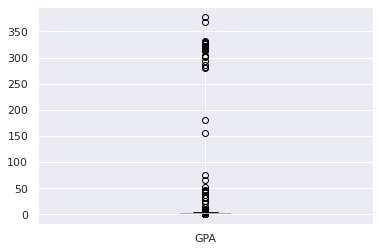

In [16]:
df_train[['GPA']].boxplot()

In [17]:
df_train[['GPA']].describe()

,GPA
count,11153.000000
mean,3.176195
std,13.321687
min,0.000000
25%,2.820000
50%,3.070000
75%,3.270000
max,378.000000


In [18]:
df_train[df_train['GPA'] > 4][['GPA']].head()

,GPA
1,7.28
4,7.20
9,4.19
12,8.30
15,6.82


In [19]:
df_train[df_train['GPA'] > 4][['GPA']].count()

GPA    52
dtype: int64

In [20]:
df_train[df_train['GPA'] == 0][['GPA']].count()

GPA    2148
dtype: int64

In [21]:
df_train[df_train['GPA'] > 4].groupby('Education_level').Education_level.count()

Education_level
level_1    32
level_3     1
level_4    19
Name: Education_level, dtype: int64

In [22]:
len(df_train[df_train['GPA'] > 4])

52

In [23]:
len(df_test[df_test['GPA'] > 4])

31

In [24]:
def transform_gpa(gpa: float) -> float:
    if not isinstance(gpa, (float, np.float_)):
        raise ValueError(f'Invalid GPA: {gpa}')
    if gpa > 4:
        gpa = 0
    return gpa

print(df_train['GPA'][1], ' -> ', transform_gpa(df_train['GPA'][1]))
print(df_train['GPA'][4], ' -> ', transform_gpa(df_train['GPA'][4]))

7.28  ->  0
7.2  ->  0


## Job Level

In [25]:
def transform_job_level(job_level: str) -> int:
    job_level_ordinal = {
        'JG06' : 3,
        'JG05' : 2,
        'JG04' : 1,
        'JG03' : 0
    }.get(job_level)

    if job_level_ordinal is None:
        raise ValueError(f'Invalid job level: {job_level}')

    return job_level_ordinal

print(df_train['job_level'][0], ' -> ', transform_job_level(df_train['job_level'][0]))
print(df_train['job_level'][1], ' -> ', transform_job_level(df_train['job_level'][1]))

JG04  ->  1
JG04  ->  1


In [26]:
df_train[df_train['job_level'] == 'JG04'][['job_level']].count()

job_level    10413
dtype: int64

## Person Level

In [27]:
def transform_person_level(person_level: str) -> int:
    person_level_ordinal = {
        'PG08' : 7,
        'PG07' : 6,
        'PG06' : 5,
        'PG05' : 4,
        'PG04' : 3,
        'PG03' : 2,
        'PG02' : 1,
        'PG01' : 0
    }.get(person_level)

    if person_level_ordinal is None:
        raise ValueError(f'Invalid person level: {person_level}')

    return person_level_ordinal

print(df_train['person_level'][0], ' -> ', transform_person_level(df_train['person_level'][0]))
print(df_train['person_level'][1], ' -> ', transform_person_level(df_train['person_level'][1]))

PG03  ->  2
PG03  ->  2


## Education Level

In [28]:
def transform_education_level(education_level: str) -> int:
    education_level_ordinal = {
        'level_5' : 5,
        'level_4' : 4,
        'level_3' : 3,
        'level_2' : 2,
        'level_1' : 1,
        'level_0' : 0
    }.get(education_level)

    if education_level_ordinal is None:
        raise ValueError(f'Invalid education level: {education_level}')

    return education_level_ordinal

print(df_train['Education_level'][0], ' -> ', transform_education_level(df_train['Education_level'][0]))
print(df_train['Education_level'][1], ' -> ', transform_education_level(df_train['Education_level'][1]))

level_0  ->  0
level_1  ->  1


## Transform The Dataframe

In [29]:
def transform_df(df: pd.DataFrame):
    df_transformed = df.copy()
    df_transformed = df_transformed.dropna()
    df_transformed['gender'] =  df_transformed['gender'].map(lambda gender: transform_gender(gender))
    df_transformed['year_graduated'] =  df_transformed['year_graduated'].map(lambda year_graduated: transform_year_graduated(year_graduated))
    df_transformed['age'] =  df_transformed['age'].map(lambda age: transform_age(age))
    df_transformed['GPA'] =  df_transformed['GPA'].map(lambda gpa: transform_gpa(gpa))
    df_transformed['job_level'] =  df_transformed['job_level'].map(lambda job_level: transform_job_level(job_level))
    df_transformed['person_level'] =  df_transformed['person_level'].map(lambda person_level: transform_person_level(person_level))
    df_transformed = pd.get_dummies(df_transformed, drop_first=True)
    return df_transformed

In [30]:
df_train_transformed = transform_df(df_train)

In [31]:
df_train_transformed.shape

(11152, 27)

In [32]:
df_train_transformed

,job_level,job_duration_in_current_job_level,person_level,job_duration_in_current_person_level,job_duration_in_current_branch,age,number_of_dependences,GPA,year_graduated,job_duration_from_training,branch_rotation,job_rotation,assign_of_otherposition,annual leave,sick_leaves,Last_achievement_%,Achievement_above_100%_during3quartal,Best Performance,Employee_type_RM_type_B,Employee_type_RM_type_C,gender_2,marital_status_maried(Y/N)_Y,Education_level_level_1,Education_level_level_2,Education_level_level_3,Education_level_level_4,Education_level_level_5
0,1,1.352775,2,1.352775,1.732051,36,1,2.86,10,4,2,3,2,3,0,46.37,0.0,0,0,0,1,1,0,0,0,0,0
1,1,1.292285,2,1.292285,1.039230,32,0,0.00,14,4,4,3,0,0,1,47.68,0.0,0,0,0,1,1,1,0,0,0,0
2,2,2.565151,5,2.308679,1.780449,51,1,0.00,32,28,10,9,6,2,1,40.73,0.0,0,0,1,0,1,1,0,0,0,0
3,2,2.828427,5,1.000000,1.385641,54,2,0.00,34,29,11,6,0,4,10,47.42,0.0,1,0,0,1,1,1,0,0,0,0
4,2,2.828427,5,2.828427,0.707107,56,3,0.00,36,30,9,8,2,3,0,47.18,0.0,0,0,0,1,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11148,1,1.256981,2,1.256981,1.224745,35,1,3.33,5,4,3,3,0,4,1,50.87,0.0,0,0,0,1,1,0,0,0,0,1
11149,1,1.385641,2,1.385641,1.802776,33,2,3.00,6,3,1,2,0,6,0,79.91,0.0,0,1,0,0,1,0,0,0,0,1
11150,1,1.256981,2,1.256981,1.385641,30,0,3.48,4,2,1,2,0,4,0,78.38,0.0,0,1,0,1,1,0,0,0,0,1
11151,1,1.118034,2,1.118034,0.000000,34,1,3.53,9,5,5,4,0,4,1,85.94,1.0,0,0,0,0,1,0,0,0,0,1


In [33]:
X = df_train_transformed.drop('Best Performance', axis=1)
y = df_train_transformed['Best Performance']

# 4. Train The Model

In [53]:
def train_model(model: ClassifierMixin):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
    scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    print('ROC-AUC Score: ', round(np.mean(scores),5))

### Logistic Regression

In [54]:
lr = LogisticRegression()
train_model(lr)

ROC-AUC Score:  0.52482


### Random Forest

In [55]:
rf = RandomForestClassifier(n_estimators=400, random_state=42)
train_model(rf)

ROC-AUC Score:  0.56817


### Decision Tree

In [56]:
dt = DecisionTreeClassifier(random_state=42)
train_model(dt)

ROC-AUC Score:  0.5183


### Balanced Bagging Classifier

In [57]:
bbc = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                n_estimators = 1000,
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=42)
train_model(bbc)

ROC-AUC Score:  0.58247


## Train The Model on Whole Training Set

In [58]:
model = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                n_estimators = 1000,
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=42)
model.fit(X, y)

BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                          n_estimators=1000, random_state=42)

In [59]:
print(f'Accuracy: {model.score(X, y)}')
print(f'ROC AUC score: {roc_auc_score(y, model.predict_proba(X)[:,1])}')

Accuracy: 0.9644010043041606
ROC AUC score: 0.9999780111202741


# 5. Apply The Trained Model on Test Set

In [60]:
df_test.shape

(6000, 21)

In [61]:
X_test = transform_df(df_test)

In [62]:
X_test.shape

(6000, 26)

In [63]:
X_test.head()

,job_level,job_duration_in_current_job_level,person_level,job_duration_in_current_person_level,job_duration_in_current_branch,age,number_of_dependences,GPA,year_graduated,job_duration_from_training,branch_rotation,job_rotation,assign_of_otherposition,annual leave,sick_leaves,Last_achievement_%,Achievement_above_100%_during3quartal,Employee_type_RM_type_B,Employee_type_RM_type_C,gender_2,marital_status_maried(Y/N)_Y,Education_level_level_1,Education_level_level_2,Education_level_level_3,Education_level_level_4,Education_level_level_5
0,1,1.256981,2,1.256981,0.707107,33,0,3.08,12,6,4,2,6,3,7,84.02,0.0,0,0,0,0,0,0,1,0,0
1,1,1.224745,2,1.224745,1.256981,30,0,3.31,7,2,2,2,0,1,0,63.74,0.0,1,0,1,0,0,0,0,1,0
2,1,0.500000,2,0.500000,1.081665,32,1,3.44,10,4,2,2,0,2,1,88.19,1.0,0,0,1,1,0,0,0,1,0
3,1,1.256981,2,1.256981,1.802776,31,1,0.00,7,3,1,3,0,3,0,25.94,0.0,0,0,1,1,0,0,0,1,0
4,1,1.352775,2,1.352775,1.224745,36,0,3.34,14,5,3,2,0,3,0,82.32,0.0,1,0,0,1,0,0,0,1,0


In [64]:
y_test_pred_proba = model.predict_proba(X_test)[:,1]

In [65]:
y_test_pred_proba

array([0.332, 0.386, 0.663, ..., 0.543, 0.487, 0.333])

# 6. Make Submission File

In [66]:
submission = pd.Series(y_test_pred_proba, name='Best Performance')

In [67]:
submission

0       0.332
1       0.386
2       0.663
3       0.323
4       0.302
        ...  
5995    0.382
5996    0.239
5997    0.543
5998    0.487
5999    0.333
Name: Best Performance, Length: 6000, dtype: float64

In [68]:
submission.to_csv('Submission 25-Feb #2.csv', index_label = 'index')

In [69]:
submission.to_csv('submission.csv', index_label = 'index')